<a href="https://colab.research.google.com/github/soyudea/StrokePredictionModel/blob/main/05_modelo_RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score

**Carga del dataset** https://www.kaggle.com/competitions/playground-series-s3e2/data?select=train.csv

In [ ]:
#Se carga dataset obtenido de Kaggle de competencia
#==============================================================
datos = pd.read_csv('train.csv', sep=",")
datos_test = pd.read_csv('test.csv', sep=",")
df =datos.copy()
df_test=datos_test.copy()

**Se agregan valores nulos al 5 % de las muestras en los campos age, avg_glucose_level**

In [ ]:
#Se adiciona valores nulos al atributo age y avg_glucose_level
#=============================================================
#df =datos.copy()
lista=[]
porc_nulos =int(np.shape(df)[0]*5/100)   #Calculo de porcentaje de datos nulos
rango_df = np.shape(df)[0]

for i in range(porc_nulos):
    num_aleatprio = np.random.randint(rango_df) 
    lista.append(num_aleatprio)


for i in lista:
    df.at[i, "age"] = np.nan

lista=[]
rango_df = np.shape(df)[0]

for i in range(porc_nulos):
    num_aleatprio = np.random.randint(rango_df) 
    lista.append(num_aleatprio)


for i in lista:
    df.at[i, "avg_glucose_level"] = np.nan

**Estado del dataset despues de agregar valores nulos**

In [ ]:
#Lectura del dataSet
#==============================================================
datos = pd.read_csv('train.csv', sep=",")
datos_test = pd.read_csv('test.csv', sep=",")
df =datos.copy()
df_test=datos_test.copy()

**Se agregan valores promedios en aquellas muestras con valores nulos**

In [ ]:
#Se agregan valores promedios al atributo age cuando son nulos
#==================================================================

mean_age = df['age'].mean().astype(int) #Calculo media de las edades

for i in range(len(df)):
    if math. isnan(df.at[i, "age"]):
       df.at[i, "age"] = mean_age

In [ ]:
#Se agrega valores promedios al atributo avg_glucose_level cuando son nulos
#===============================================================================================
mean_avg_glucose_level = df['avg_glucose_level'].mean().astype(int) #Calculo media de las edades

for i in range(len(df)):
    if math. isnan(df.at[i, "avg_glucose_level"]):
       df.at[i, "avg_glucose_level"] = mean_avg_glucose_level

**Estado final del dataset despues de reemplazar valores nulos con valores promedios**

In [ ]:
datos['age'] = datos['age'].astype('int64') 
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  int64  
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 1.4+ MB


In [ ]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Discretización de las variables 'age', 'avge_glucose_level', 'bmi'**

In [ ]:
#Se transforma campo numerico age a un atributo con valores categoricos, se discretisa
#========================================================================================================================================================

df = datos.copy()

edades = pd.cut(df['age'], bins = [0,10,20,40,np.inf], labels =['niño','joven','adulto','mayor'], include_lowest=True, retbins = True)
df['new_age'] = list(edades[0]) 

glucosa = pd.cut(df['avg_glucose_level'], bins = [0,100,125,np.inf], labels = ['normal', 'prediabetico','diabetico'], include_lowest=True, retbins=True)
df["avg_glucose"] = list(glucosa[0])

im = pd.cut(df['bmi'], bins = [18.5,24.9,25,29.9,np.inf], labels = ['low_weight', 'Healthy_weight','overweight','obesity'], include_lowest=True, retbins=True)
df['bmi_range'] = list(im[0])
df.shape

(15304, 15)

**Transformación del dataset, de variables categoricas a númericas**

In [ ]:
#Se obtiene un dataset con todos sus atributos numéricos
#========================================================================================================================================================================================================================================
#Quitar la variable work_type

vnumericas = df.drop(["id","avg_glucose_level","age","bmi","new_age","avg_glucose","bmi_range","gender","ever_married","work_type","Residence_type","smoking_status", "bmi_range"],axis=1)#SE crea variable númerica sin las categoricas 
vcategoricas=df.filter(["new_age","avg_glucose","bmi_range","gender","ever_married","work_type","Residence_type","smoking_status", "bmi_range"]) 

cat_numerica=pd.get_dummies(vcategoricas,drop_first=False) 
df=pd.concat([cat_numerica,vnumericas],axis=1)

df.shape

(15304, 34)

**Organización del dataset final**

In [ ]:
X = df[:len(df)]
y = df['stroke']
X = X.drop(columns=['stroke'])
X.columns
X.shape

(15304, 33)

**Generador de muestras sintéticas**

In [ ]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409,) (2935, 30) (2935,)


**Calculo pesos de la clase Parametro que se usa para minimizar el efecto del desbalance del dataset**

In [ ]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**Modelo de clasificación random Forest Entrenamiento con el 90 % de los datos**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
weight = dar_peso_clase() 
kf = KFokf = KFold(n_splits=10, random_state = True,shuffle=True)

#max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”
#  random_state=True,
#min_weight_fraction_leaf=0.00005,
#n_estimators=5,
#min_impurity_decrease=0.005,
# ccp_alpha=0.000001,
# max_features ="sqrt",
#  warm_start=True,
#  n_jobs=2,

X_test =0
Y_test =0

#warm_start mejoro la velocidad de ejecucion, mejoró la metrica
classifier = RandomForestClassifier(min_samples_split=10,
                                    ccp_alpha=0.000001,
                                    criterion='gini',
                                    class_weight = {0: weight[0], 1: weight[1]},
                                    random_state=True,max_features ="sqrt",
                                    warm_start=True,min_impurity_decrease=0.000005)

for train_index, test_index in kf.split(X):
    
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    modelo = classifier.fit(Xtrain, ytrain)
    ypred = modelo.predict(Xtest)

    print()
    print(confusion_matrix(ytest, ypred))
    print(classification_report(ytest, ypred, digits =4, labels=[0,1]))
    s = roc_auc_score(ytest, modelo.predict(Xtest))
    print(f'Best val auc: {s: .4f}')


[[1003  342]
 [ 157 1139]]
              precision    recall  f1-score   support

           0     0.8647    0.7457    0.8008      1345
           1     0.7691    0.8789    0.8203      1296

    accuracy                         0.8111      2641
   macro avg     0.8169    0.8123    0.8106      2641
weighted avg     0.8178    0.8111    0.8104      2641

Best val auc:  0.8123

[[ 999  324]
 [ 141 1177]]
              precision    recall  f1-score   support

           0     0.8763    0.7551    0.8112      1323
           1     0.7841    0.8930    0.8350      1318

    accuracy                         0.8239      2641
   macro avg     0.8302    0.8241    0.8231      2641
weighted avg     0.8303    0.8239    0.8231      2641

Best val auc:  0.8241


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[1010  340]
 [ 139 1152]]
              precision    recall  f1-score   support

           0     0.8790    0.7481    0.8083      1350
           1     0.7721    0.8923    0.8279      1291

    accuracy                         0.8186      2641
   macro avg     0.8256    0.8202    0.8181      2641
weighted avg     0.8268    0.8186    0.8179      2641

Best val auc:  0.8202

[[1017  341]
 [ 158 1125]]
              precision    recall  f1-score   support

           0     0.8655    0.7489    0.8030      1358
           1     0.7674    0.8769    0.8185      1283

    accuracy                         0.8111      2641
   macro avg     0.8165    0.8129    0.8107      2641
weighted avg     0.8179    0.8111    0.8105      2641



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Best val auc:  0.8129

[[ 988  329]
 [ 137 1187]]
              precision    recall  f1-score   support

           0     0.8782    0.7502    0.8092      1317
           1     0.7830    0.8965    0.8359      1324

    accuracy                         0.8236      2641
   macro avg     0.8306    0.8234    0.8225      2641
weighted avg     0.8305    0.8236    0.8226      2641

Best val auc:  0.8234



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


[[ 969  342]
 [ 148 1182]]
              precision    recall  f1-score   support

           0     0.8675    0.7391    0.7982      1311
           1     0.7756    0.8887    0.8283      1330

    accuracy                         0.8145      2641
   macro avg     0.8215    0.8139    0.8132      2641
weighted avg     0.8212    0.8145    0.8134      2641

Best val auc:  0.8139

[[ 942  338]
 [ 153 1208]]
              precision    recall  f1-score   support

           0     0.8603    0.7359    0.7933      1280
           1     0.7814    0.8876    0.8311      1361

    accuracy                         0.8141      2641
   macro avg     0.8208    0.8118    0.8122      2641
weighted avg     0.8196    0.8141    0.8128      2641

Best val auc:  0.8118

[[ 981  358]
 [ 125 1177]]
              precision    recall  f1-score   support

           0     0.8870    0.7326    0.8025      1339
           1     0.7668    0.9040    0.8297      1302

    accuracy                         0.8171      2641
 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


              precision    recall  f1-score   support

           0     0.8730    0.7460    0.8045      1299
           1     0.7845    0.8949    0.8361      1342

    accuracy                         0.8217      2641
   macro avg     0.8287    0.8204    0.8203      2641
weighted avg     0.8280    0.8217    0.8205      2641

Best val auc:  0.8204

[[ 961  308]
 [ 144 1227]]
              precision    recall  f1-score   support

           0     0.8697    0.7573    0.8096      1269
           1     0.7993    0.8950    0.8445      1371

    accuracy                         0.8288      2640
   macro avg     0.8345    0.8261    0.8270      2640
weighted avg     0.8332    0.8288    0.8277      2640

Best val auc:  0.8261


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


**Curva ROC, RandomForest**


Sin entrenar: ROC AUC=0.500
Algoritmo RandomForest: ROC AUC=0.826




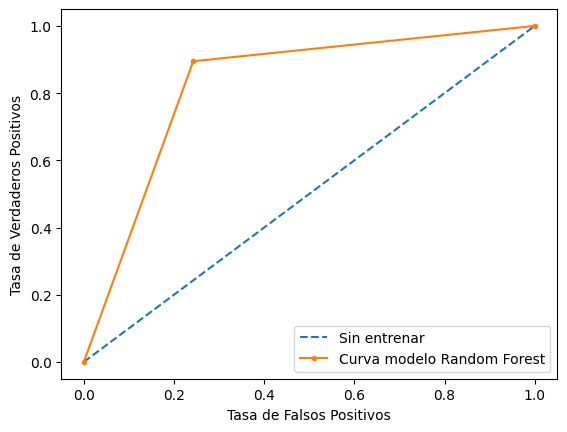

In [ ]:
classes = classifier.predict(Xtest)
ns_probs = [0 for _ in range(len(ytest))]
ns_auc = roc_auc_score(ytest, ns_probs,average='weighted')
classifier_auc = roc_auc_score(ytest,classes,average='weighted')
#aps = average_precision_score(ytest, ns_probs)
print()
#print("Average_presicion_score "+str(aps))
print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo RandomForest: ROC AUC=%.3f' % (classifier_auc))
print()
classifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
classifier_fpr,classifier_tpr, _ = roc_curve(ytest, classifier_probs)
print()
pyplot.plot(classifier_fpr,classifier_tpr, marker='.', label='Curva modelo Random Forest')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()